## Import Libraries

In [1]:
# Importing libraries for data manipulation, analysis and visualization
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# NLTK (Natural Language Toolkit) for text processing and analysis
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import contractions

# Scikit-learn for machine learning models and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim.downloader as api

In [2]:
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [3]:
# Downloading required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [4]:
# Load Sentiment140 dataset and assign column names for clarity
sentiment_df = pd.read_csv("dataset/Sentiment140.csv", header=None, encoding='ISO-8859-1')
sentiment_df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
sentiment_df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
def preprocess_text(text):
    """
    Preprocesses the given text for NLP tasks.
    
    This includes expanding contractions, removing URLs, usernames, hashtags, 
    and non-alphabetic characters, converting to lowercase, 
    removing stopwords, and lemmatizing the text.
    
    Args:
    text (str): The text to preprocess.

    Returns:
    str: The preprocessed and lemmatized text.
    """
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)   # Remove usernames and hashtags
    text = re.sub(r'[^A-Za-z\'\s]', '', text)  # Keep only alphabetic characters
    tokens = word_tokenize(text)  # Tokenize and convert to lowercase
    tokens = [token.lower() for token in tokens]  # Tokenize and convert to lowercase
    stop_words = set(stopwords.words('english'))   # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(token) for token in filtered_tokens]  # Lemmatize the tokens
    return ' '.join(lemmatized_text)


sentiment_df['cleaned_text'] = sentiment_df['text'].apply(preprocess_text)
sentiment_df.head()

,sentiment,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see


## Exploratory Data Analysis (EDA)

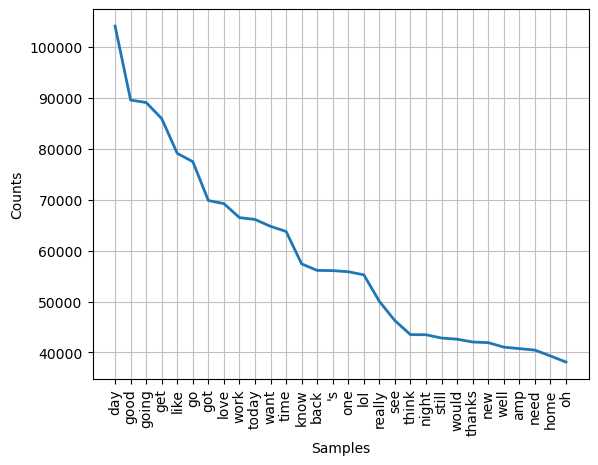

In [6]:
def visualize_word_frequencies(dataframe, text_column='cleaned_text'):
    """
    Visualize the frequency distribution of words in the specified text column of the dataframe.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the text data.
    text_column (str): The name of the column in the DataFrame containing the text. Defaults to 'cleaned_text'.

    """
    all_words = ' '.join(dataframe[text_column]).split()
    freq_dist = FreqDist(all_words)
    freq_dist.plot(30, cumulative=False)
    plt.show()

visualize_word_frequencies(sentiment_df)

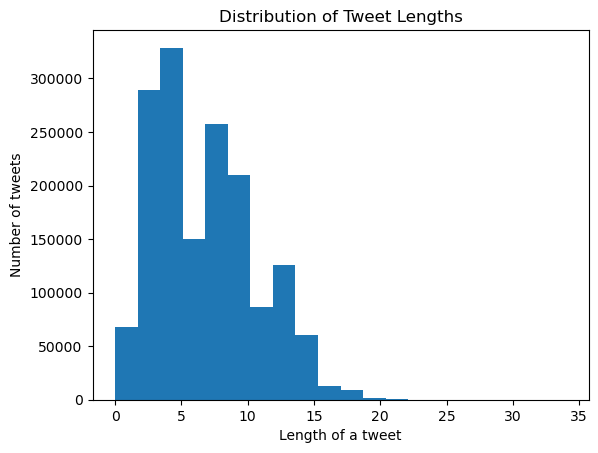

In [7]:
def analyze_tweet_lengths(dataframe, text_column='cleaned_text'):
    """
    Analyze and plot the distribution of tweet lengths in the specified text column of the dataframe.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the text data.
    text_column (str): The name of the column in the DataFrame containing the text. Defaults to 'cleaned_text'.

    """
    dataframe['tweet_length'] = dataframe[text_column].apply(lambda x: len(x.split()))
    plt.hist(dataframe['tweet_length'], bins=20)
    plt.title('Distribution of Tweet Lengths')
    plt.xlabel('Length of a tweet')
    plt.ylabel('Number of tweets')
    plt.show()

analyze_tweet_lengths(sentiment_df)

Word Cloud for Positive Sentiments:


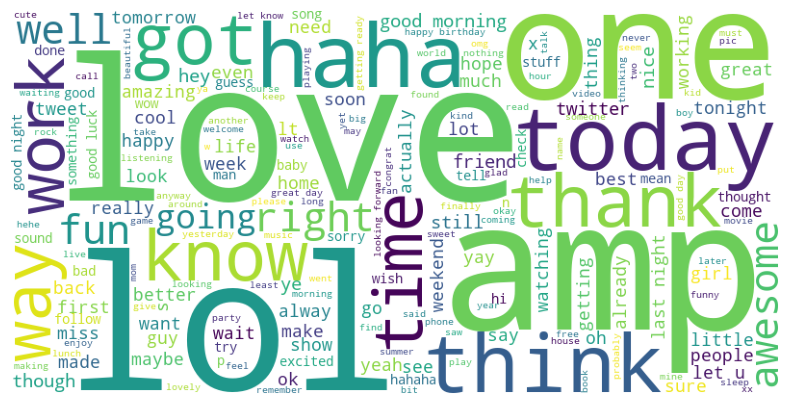

Word Cloud for Negative Sentiments:


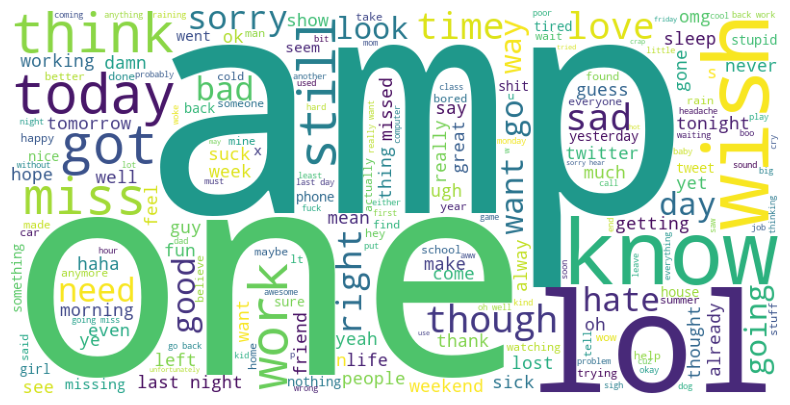

In [8]:
def create_sentiment_wordclouds(dataframe, sentiment_column='sentiment', text_column='cleaned_text'):
    """
    Create and display word clouds for positive and negative sentiments based on the specified sentiment and text columns.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the sentiment and text data.
    sentiment_column (str): The name of the column in the DataFrame containing sentiment labels. Defaults to 'sentiment'.
    text_column (str): The name of the column in the DataFrame containing the text. Defaults to 'cleaned_text'.

    """
    positive_text = ' '.join(dataframe[dataframe[sentiment_column] == 4][text_column])  # Extract text for positive and negative sentiments
    negative_text = ' '.join(dataframe[dataframe[sentiment_column] == 0][text_column])
    def generate_wordcloud(text):  # Generate and display a word cloud from the text
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

    print("Word Cloud for Positive Sentiments:")
    generate_wordcloud(positive_text)
    print("Word Cloud for Negative Sentiments:")
    generate_wordcloud(negative_text)

create_sentiment_wordclouds(sentiment_df)

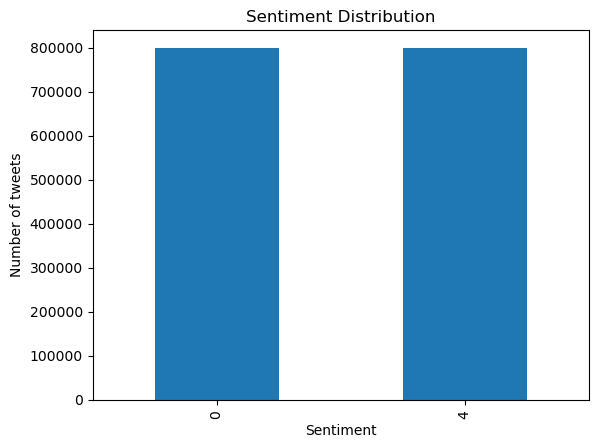

In [9]:
def visualize_sentiment_distribution(dataframe, sentiment_column='sentiment'):
    """
    Visualize the distribution of sentiments in the specified sentiment column of the dataframe.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the sentiment data.
    sentiment_column (str): The name of the column in the DataFrame containing sentiment labels. Defaults to 'sentiment'.
    """
    # Plot the sentiment distribution
    dataframe[sentiment_column].value_counts().plot(kind='bar')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of tweets')
    plt.show()

visualize_sentiment_distribution(sentiment_df)

In [10]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(sentiment_df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [11]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
def tokenize_data(df, tokenizer):
    return tokenizer(
        list(df['cleaned_text']),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [13]:
# Create PyTorch datasets
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = TweetDataset(train_encodings, train_df['sentiment'].tolist())
val_dataset = TweetDataset(val_encodings, val_df['sentiment'].tolist())
test_dataset = TweetDataset(test_encodings, test_df['sentiment'].tolist())

In [20]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)


In [22]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_datasetççç=train_dataset,
    eval_dataset=val_dataset
)
trainer.train()

/var/folders/3n/qbd4zl351zv9lx7zwq0gf89w0000gn/T/ipykernel_7646/4088793631.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss


/var/folders/3n/qbd4zl351zv9lx7zwq0gf89w0000gn/T/ipykernel_7646/4088793631.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/3n/qbd4zl351zv9lx7zwq0gf89w0000gn/T/ipykernel_7646/4088793631.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/3n/qbd4zl351zv9lx7zwq0gf89w0000gn/T/ipykernel_7646/4088793631.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key

KeyboardInterrupt: 

In [ ]:
trainer.evaluate(test_dataset)

In [ ]:
model.save_pretrained('./my_sentiment_model')

In [ ]:
loaded_model = BertForSequenceClassification.from_pretrained('./my_sentiment_model')
sentiment_analysis = pipeline("sentiment-analysis", model=loaded_model, tokenizer=tokenizer)

In [ ]:
result = sentiment_analysis("I love this!")
print(result)

## Feature Extraction

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(sentiment_df['cleaned_text'])

### Word Embeddings - Word2Vec

In [ ]:
def vectorize_text(text, word_vectors):
    word_vecs = [word_vectors[word] for word in text.split() if word in word_vectors]
    if len(word_vecs) == 0:
        return np.zeros(word_vectors.vector_size)
    else:
        return np.mean(word_vecs, axis=0)

word_vectors = api.load("word2vec-google-news-300")
sentiment_df['feature_vector'] = sentiment_df['cleaned_text'].apply(lambda x: vectorize_text(x, word_vectors))
sentiment_df.head()

### Bag of Words

In [ ]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(sentiment_df['cleaned_text'])

## Model Training and Validation

In [ ]:
y = sentiment_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
def calculate_performance_metrics(conf_matrix, accuracy, classifier_name):
    TN, FP, FN, TP = conf_matrix.ravel()
    
    truePositiveRate = TP / (TP + FN)
    trueNegativeRate = TN / (TN + FP)
    
    performance_measure = {
        "classifier": [classifier_name],
        'TP': [TP],
        'FP': [FP],
        'TN': [TN],  
        'FN': [FN],
        'accuracy': [round(accuracy, 3) * 100],
        'TPR': [round(truePositiveRate, 3)*100],
        'TNR': [round(trueNegativeRate, 3)*100 ]
    }
    
    return pd.DataFrame(performance_measure)

### Random Forest

In [ ]:
N = range(1, 11)
D = range(1, 6)
error_rates = np.zeros((len(N), len(D)))

for i, n in enumerate(N):
    for j, d in enumerate(D):
        model = RandomForestClassifier(n_estimators=n, max_depth=d, criterion='entropy', random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, predictions)
        error_rates[i, j] = error_rate

plt.figure(figsize=(10, 8))
for i, d in enumerate(D):
    plt.plot(N, error_rates[:, i], label=f'Max Depth = {d}')
plt.xlabel('Number of Trees (N)')
plt.ylabel('Error Rate')
plt.title('Error Rates for Different N and d Combinations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_error_index = np.unravel_index(np.argmin(error_rates, axis=None), error_rates.shape)
optimal_N = N[min_error_index[0]]
optimal_d = D[min_error_index[1]]
optimal_error_rate = error_rates[min_error_index]

optimal_N, optimal_d, optimal_error_rate

In [ ]:
RandonForest = RandomForestClassifier(n_estimators=optimal_N, max_depth=optimal_d, random_state=42)
RandonForest.fit(X_train, y_train)
RandonForest_predictions = RandonForest.predict(X_test)

RandonForest_accuracy = accuracy_score(y_test, RandonForest_predictions)
RandonForest_confussion = confusion_matrix(RandonForest_predictions, y_test)

random_forest_performance = calculate_performance_metrics(RandonForest_confussion, RandonForest_accuracy, "Random Forest")
RandonForest_PerformanceMeasure

### Logistic regression

In [ ]:
logisticRegression = LogisticRegression(max_iter=1000)
logisticRegression.fit(X_train, y_train)

logisticRegression_predictions = logisticRegression.predict(X_test)
logisticRegression_accuracy = accuracy_score(logisticRegression_predictions, y_test)

logisticRegression_confussion = confusion_matrix(logisticRegression_predictions, y_test)

logisticRegression_PerformanceMeasure = calculate_performance_metrics(logisticRegression_confussion, logisticRegression_accuracy, "Logistic Regression")
logisticRegression_PerformanceMeasure

## Summary

In [ ]:
classifier_df = pd.concat([logisticRegression_PerformanceMeasure, RandonForest_PerformanceMeasure], ignore_index=True)
classifier_df

In [23]:
pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers

In [18]:
# Check if Apple Silicon GPU is available and use it; otherwise, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [19]:
print(device)

mps
